In [262]:
import pandas as pd
import pandas_datareader as dr
import numpy as np 
import yfinance as yf

from analysis.data.utils_analysis import create_full_dataset
ESG = pd.read_csv(r"C:\Users\m.narese\Desktop\THESIS\REPO\portfolio_optimization\analysis\datasets\1\ESG_data.csv")
tickers = list(ESG['ticker'].unique())
print("Total number of tickers", len(tickers))

raw = yf.download(tickers, start="2020-01-01", end="2025-01-01", auto_adjust=True)

Total number of tickers 722


[*********************100%***********************]  722 of 722 completed

79 Failed downloads:
['AGTC', 'ACRX', 'ALBO', 'PNT', 'AGRX', 'GVP', 'CND', 'POW', 'PKI', 'AIH', 'ACEV', 'XL', 'AGFS', 'ABMD', 'ACAC', 'HEP', 'SIEN', 'ADMP', 'ADES', 'DISH', 'MYMD', 'NLOK', 'ACOR', 'ABIO', 'FISV', 'AKU', 'AACI', 'AIKI', 'ATVI', 'FLT', 'CDAY', 'HCCI', 'HHC', 'HAPP', 'HARP', 'ABTX', 'AGIL', 'CLXT', 'AIMC', 'SIVB', 'EVK', 'ABC', 'ALIM', 'CLVS', 'AFAQ', 'ZEV', 'ADOC', 'GPS', 'FBHS', 'USAK', 'HCAR', 'NLSN', 'DRE', 'UTME', 'PEAK', 'ZEN', 'HAAC', 'AEY', 'RE', 'AESE', 'ACER', 'WWE', 'AKUS', 'AAWW', 'FRC', 'AERI', 'PXD', 'TRTN', 'HA', 'AKIC', 'WRK', 'AGLE', 'CTXS', 'CLSN', 'HCDI']: YFTzMissingError('$%ticker%: possibly delisted; no timezone found')
['HAYN']: YFPricesMissingError('$%ticker%: possibly delisted; no price data found  (1d 2020-01-01 -> 2025-01-01) (Yahoo error = "No data found, symbol may be delisted")')
['Y']: %ticker%FTzMissingError('$%ticker%: possibly delisted; no timezone found')
['AHPI', 

In [263]:
dataset = pd.DataFrame(raw)
missing_frac = dataset.isnull().mean().sort_values(ascending=False)
drop_list = sorted(list(missing_frac[missing_frac > 0.2].index))
dataset.drop(columns=drop_list, axis = 1, inplace=True)
dataset.fillna(method='bfill', axis='index', inplace=True)
print('Null values:', dataset.isnull().values.any())


Null values: True


C:\Users\m.narese\AppData\Local\Temp\ipykernel_19464\1677383752.py:5: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  dataset.fillna(method='bfill', axis='index', inplace=True)


In [264]:
import quantstats as qs

def data_vertical(data):
    dataset_vertical = data.stack(level=1).reset_index()
    dataset_vertical.rename(columns={'level_1': 'Ticker'}, inplace=True)
    dataset_vertical['Date'] = pd.to_datetime(dataset_vertical['Date'])  # Ensure 'Date' column exists
    dataset_vertical.set_index('Date', inplace=True)
    return dataset_vertical
    


def feature_engineering(data):
    #avg returns
    returns = data["Close"].pct_change().mean()*252
    returns = pd.DataFrame(returns)
    final_dataframe = returns.reset_index()
    final_dataframe = final_dataframe.rename(columns={final_dataframe.columns[1]:"Yavg_return"})
    #volatility
    final_dataframe["Yavg_volatility"] = np.array(data["Close"].pct_change().std()*np.sqrt(252))

    dataset_vertical = data_vertical(data)
    dataset_vertical["daily_span"] = dataset_vertical["High"]- dataset_vertical["Low"]
    #daily_span
    final_dataframe["Davg_span"] = np.array(dataset_vertical.groupby("Ticker")["daily_span"].mean())
    #traded volume
    final_dataframe["Davg_volume"] = np.array(dataset_vertical.groupby("Ticker")["Volume"].mean())
    #skewness
    final_dataframe["D_eSkewness"] = np.array(dataset_vertical.groupby("Ticker")["Close"].apply(qs.stats.skew))

    #VaR
    final_dataframe["D_eVaR"] = np.array(dataset_vertical.groupby("Ticker")["Close"].apply(qs.stats.value_at_risk))/(np.array(dataset_vertical.groupby("Ticker")["Close"].mean()))
    #CVaR
    final_dataframe["D_eCVaR"] = np.array(dataset_vertical.groupby("Ticker")["Close"].apply(qs.stats.expected_shortfall))/(np.array(dataset_vertical.groupby("Ticker")["Close"].mean()))
    #Curtosis
    final_dataframe["D_eCurtosis"] = np.array(dataset_vertical.groupby("Ticker")["Close"].apply(qs.stats.kurtosis))

    return final_dataframe
fdata = feature_engineering(dataset)

C:\Users\m.narese\AppData\Local\Temp\ipykernel_19464\4203454007.py:14: FutureWarning: The default fill_method='pad' in DataFrame.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not fill NA values.
  returns = data["Close"].pct_change().mean()*252
C:\Users\m.narese\AppData\Local\Temp\ipykernel_19464\4203454007.py:19: FutureWarning: The default fill_method='pad' in DataFrame.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not fill NA values.
  final_dataframe["Yavg_volatility"] = np.array(data["Close"].pct_change().std()*np.sqrt(252))
C:\Users\m.narese\AppData\Local\Temp\ipykernel_19464\4203454007.py:4: FutureWarning: The previous implementation of stack is deprecated and will be removed in a future version of pandas. See the What's New notes for panda

In [265]:
from analysis.data.utils_analysis import create_full_dataset
ESG = pd.read_csv(r"C:\Users\m.narese\Desktop\THESIS\REPO\portfolio_optimization\analysis\datasets\1\ESG_data.csv")
stock_data = create_full_dataset(fdata, ESG)
stock_data = stock_data.drop(columns=["logo", "name", "weburl", "exchange", "last_processing_date", "cik", "currency"])
print(f"The dataset has {stock_data.shape[0]} assets")
print(f"The dataset has {stock_data.shape[1]-1} predictors:")
for i in stock_data.columns:
    print(i)

The dataset has 614 assets
The dataset has 21 predictors:
Ticker
Yavg_return
Yavg_volatility
Davg_span
Davg_volume
D_eSkewness
D_eVaR
D_eCVaR
D_eCurtosis
industry
environment_grade
environment_level
social_grade
social_level
governance_grade
governance_level
environment_score
social_score
governance_score
total_score
total_grade
total_level


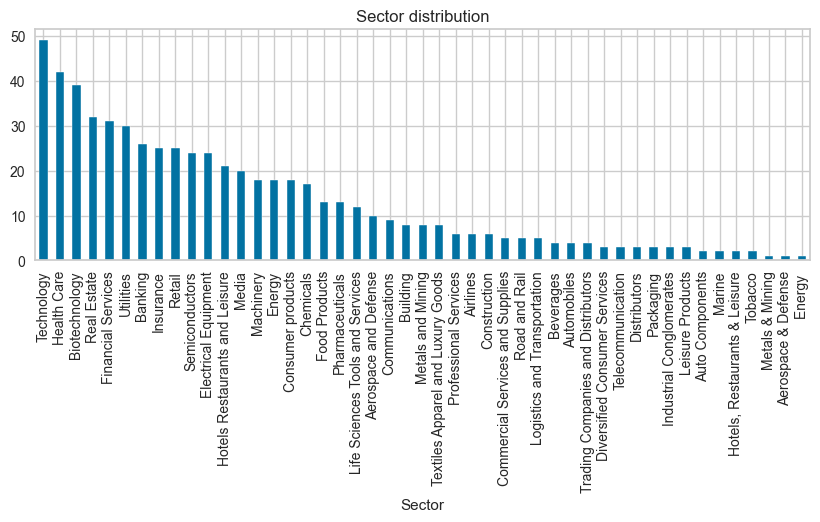

In [266]:
import matplotlib.pyplot as plt
plt.figure(figsize=(10,3))
stock_data["industry"].value_counts().plot(kind="bar")

plt.title("Sector distribution")
plt.xlabel("Sector")
plt.show()

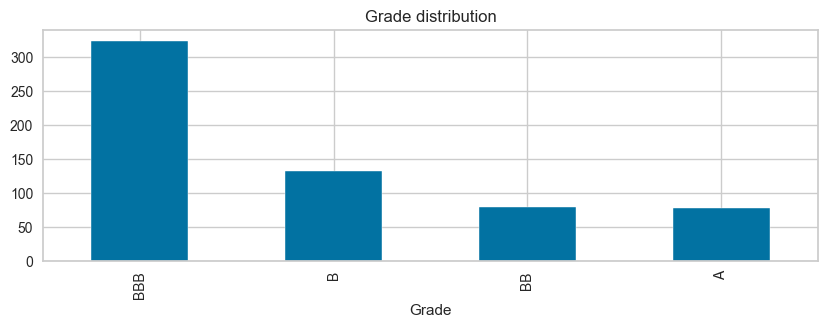

In [267]:
plt.figure(figsize=(10,3))
stock_data["total_grade"].value_counts().plot(kind="bar")

plt.title("Grade distribution")
plt.xlabel("Grade")
plt.show()

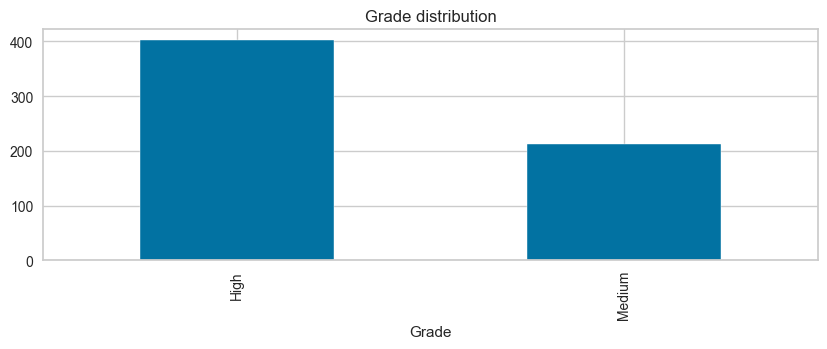

In [268]:
plt.figure(figsize=(10,3))
stock_data["total_level"].value_counts().plot(kind="bar")

plt.title("Grade distribution")
plt.xlabel("Grade")
plt.show()

In [269]:
stock_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 614 entries, 0 to 613
Data columns (total 22 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Ticker             614 non-null    object 
 1   Yavg_return        614 non-null    float64
 2   Yavg_volatility    614 non-null    float64
 3   Davg_span          614 non-null    float64
 4   Davg_volume        614 non-null    float64
 5   D_eSkewness        614 non-null    float64
 6   D_eVaR             614 non-null    float64
 7   D_eCVaR            614 non-null    float64
 8   D_eCurtosis        614 non-null    float64
 9   industry           614 non-null    object 
 10  environment_grade  614 non-null    object 
 11  environment_level  614 non-null    object 
 12  social_grade       614 non-null    object 
 13  social_level       614 non-null    object 
 14  governance_grade   614 non-null    object 
 15  governance_level   614 non-null    object 
 16  environment_score  614 non

In [270]:
stock_data_clustering = stock_data.copy()
for type, feature in zip(stock_data.dtypes, stock_data.columns):
    if type == "object" and feature!="Ticker":
        stock_data_clustering[feature] = stock_data[feature].astype('category').cat.codes

stock_data_clustering = stock_data_clustering.drop(columns=["Ticker"])
stock_data_clustering.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 614 entries, 0 to 613
Data columns (total 21 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Yavg_return        614 non-null    float64
 1   Yavg_volatility    614 non-null    float64
 2   Davg_span          614 non-null    float64
 3   Davg_volume        614 non-null    float64
 4   D_eSkewness        614 non-null    float64
 5   D_eVaR             614 non-null    float64
 6   D_eCVaR            614 non-null    float64
 7   D_eCurtosis        614 non-null    float64
 8   industry           614 non-null    int8   
 9   environment_grade  614 non-null    int8   
 10  environment_level  614 non-null    int8   
 11  social_grade       614 non-null    int8   
 12  social_level       614 non-null    int8   
 13  governance_grade   614 non-null    int8   
 14  governance_level   614 non-null    int8   
 15  environment_score  614 non-null    int64  
 16  social_score       614 non

In [271]:
from sklearn.preprocessing import StandardScaler
numerical_features = stock_data_clustering.select_dtypes(include=["float64", "int64"]).columns
categorical_features = stock_data_clustering.select_dtypes(include=["int8"]).columns
scaler = StandardScaler()
scaled_numerical = pd.DataFrame(scaler.fit_transform(stock_data_clustering[numerical_features]), columns=numerical_features)

# Combine scaled numerical features with categorical features
stock_data_clustering = pd.concat([scaled_numerical, stock_data_clustering[categorical_features].reset_index(drop=True)], axis=1)
stock_data_clustering.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 614 entries, 0 to 613
Data columns (total 21 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Yavg_return        614 non-null    float64
 1   Yavg_volatility    614 non-null    float64
 2   Davg_span          614 non-null    float64
 3   Davg_volume        614 non-null    float64
 4   D_eSkewness        614 non-null    float64
 5   D_eVaR             614 non-null    float64
 6   D_eCVaR            614 non-null    float64
 7   D_eCurtosis        614 non-null    float64
 8   environment_score  614 non-null    float64
 9   social_score       614 non-null    float64
 10  governance_score   614 non-null    float64
 11  total_score        614 non-null    float64
 12  industry           614 non-null    int8   
 13  environment_grade  614 non-null    int8   
 14  environment_level  614 non-null    int8   
 15  social_grade       614 non-null    int8   
 16  social_level       614 non

In [272]:
# for data manipulation
import numpy as np
import pandas as pd

# for data visualization
import matplotlib.pyplot as plt
import seaborn as sns

# to scale (important in clustering)
from sklearn.preprocessing import StandardScaler

#---------------------------------------------------------------------
# to compute distances for the centroid methodology (KMeans)
from scipy.spatial.distance import cdist

# to perform k-means clustering and compute silhouette scores
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

# to visualize the elbow curve and silhouette scores
from yellowbrick.cluster import KElbowVisualizer, SilhouetteVisualizer

#----------------------------------------------------------------------
# to compute distances for the hierarchical clustering
from scipy.spatial.distance import pdist

# to perform hierarchical clustering, compute cophenetic correlation, and create dendrograms
from sklearn.cluster import AgglomerativeClustering
from scipy.cluster.hierarchy import dendrogram, linkage, cophenet

# to perform PCA
from sklearn.decomposition import PCA

#----------------------------------------------------------------------
# good practice
%matplotlib inline

# to remove warnings
# import warnings
# warnings.filterwarnings('ignore')

In [288]:
clusters = range(2, 40)
meanDistortions = []
sil_score = []
runs = 50
for i in range(runs):
    run_sil = []
    run_dist = []
    for k in clusters:
        model = KMeans(n_clusters=k, random_state=i)
        model.fit(stock_data_clustering)
        prediction = model.predict(stock_data_clustering)
        score = silhouette_score(stock_data_clustering, prediction)
        distortion = (
            sum(
                np.min(cdist(stock_data_clustering, model.cluster_centers_, "euclidean"), axis=1)
            )
            / stock_data_clustering.shape[0]
        )

        run_dist.append(distortion)
        run_sil.append(score)
    sil_score.append(run_sil)
    meanDistortions.append(run_dist)
        # print("\nNumber of Clusters:", k, "\tAverage Distortion:", distortion)
        # print("For n_clusters = {}, silhouette score is {}".format(k, score))

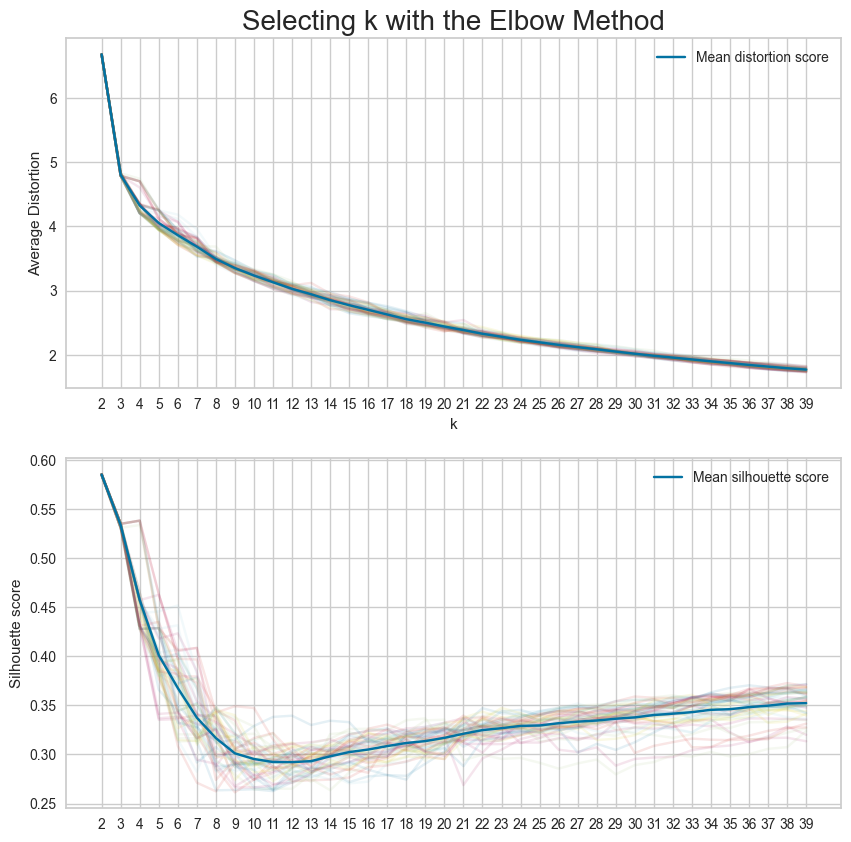

In [290]:
plt.figure(figsize=(10,10))
plt.subplot(2,1,1)
for i in range(runs): 
    plt.plot(clusters, meanDistortions[i], color=f"C{i}", alpha = 0.1)
plt.xlabel("k")
plt.ylabel("Average Distortion")
plt.xticks(clusters)
plt.title("Selecting k with the Elbow Method", fontsize=20)
plt.plot(clusters, np.mean(np.array(meanDistortions), axis=0), label="Mean distortion score")
plt.legend()
plt.subplot(2,1,2)
for i in range(runs): 
    plt.plot(clusters, sil_score[i], color=f"C{i}", alpha = 0.1)
plt.ylabel("Silhouette score")
plt.xticks(clusters)
plt.plot(clusters, np.mean(np.array(sil_score), axis=0), label="Mean silhouette score")
plt.legend()
plt.show()

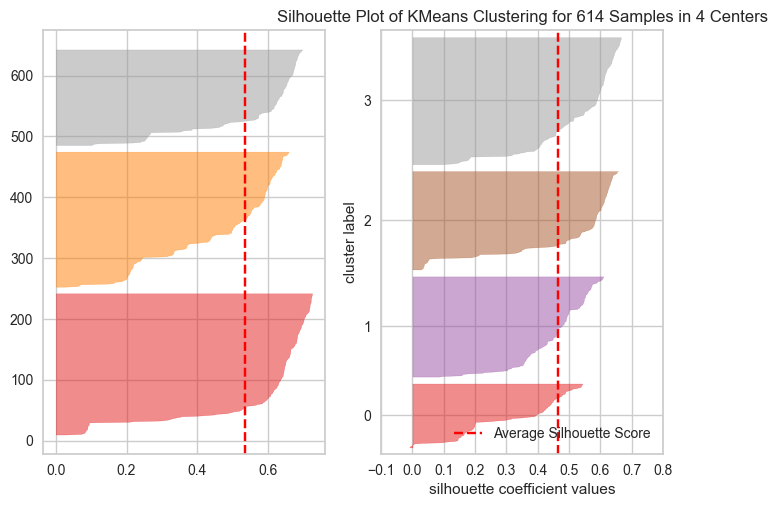

<Axes: title={'center': 'Silhouette Plot of KMeans Clustering for 614 Samples in 4 Centers'}, xlabel='silhouette coefficient values', ylabel='cluster label'>

In [291]:

plt.subplot(1,2,1)
visualizer = SilhouetteVisualizer(KMeans(3, random_state=1))
visualizer.fit(stock_data_clustering)
plt.subplot(1,2,2)
visualizer = SilhouetteVisualizer(KMeans(4, random_state=1))

visualizer.fit(stock_data_clustering)

visualizer.show()

In [293]:
N_SECTORS = 3

kmeans = KMeans(n_clusters=N_SECTORS, random_state=0)
kmeans.fit(stock_data_clustering)
stock_data["K_means_segments"] = kmeans.labels_
stock_data.head()

,Ticker,Yavg_return,Yavg_volatility,Davg_span,Davg_volume,D_eSkewness,D_eVaR,D_eCVaR,D_eCurtosis,industry,...,social_level,governance_grade,governance_level,environment_score,social_score,governance_score,total_score,total_grade,total_level,K_means_segments
0,A,0.140390,0.296676,2.810443,1.747135e+06,0.022344,-0.000241,-0.000337,3.601203,Life Sciences Tools and Services,...,Medium,B,Medium,573,231,233,1037,BBB,High,1
1,AACG,1.807258,4.376734,0.144603,4.112970e+05,32.763948,-0.283128,-0.353688,1129.391516,Diversified Consumer Services,...,Medium,B,Medium,203,200,205,608,B,Medium,2
2,AADI,0.183513,0.896398,0.980654,1.961541e+05,1.264268,-0.007005,-0.012489,33.309569,Biotechnology,...,Medium,B,Medium,200,201,203,604,B,Medium,2
3,AAL,0.087446,0.623876,0.674311,4.060582e+07,1.484921,-0.004088,-0.006008,17.648143,Airlines,...,Medium,B,Medium,270,211,265,746,B,Medium,2
4,AAME,0.275468,0.876267,0.166596,1.464938e+05,8.304785,-0.035574,-0.050234,171.219742,Insurance,...,Medium,BB,Medium,220,221,300,741,B,Medium,1


In [294]:
cluster_profile = stock_data.groupby("K_means_segments").mean(numeric_only=True)

# Add counts for the number of stocks in each cluster
cluster_profile["Count"] = stock_data.groupby("K_means_segments")["Ticker"].count().values

cluster_profile.style.highlight_max(color="green", axis=0)

,Yavg_return,Yavg_volatility,Davg_span,Davg_volume,D_eSkewness,D_eVaR,D_eCVaR,D_eCurtosis,environment_score,social_score,governance_score,total_score,Count
K_means_segments,,,,,,,,,,,,,
0,31.776586,47.945417,3.236091,6889799.705331,0.487623,-0.035808,-0.037007,21.459211,441.051643,304.150235,278.732394,1023.934272,213
1,0.359516,0.778615,3.157750,3040122.975669,0.855996,-0.004367,-0.005899,35.267033,411.029167,293.258333,278.733333,983.020833,240
2,0.132909,0.552212,147.302097,4611222.728604,0.865904,-0.005643,-0.007993,31.426866,389.366460,285.459627,279.024845,953.850932,161


In [295]:
sectorized_data = {}

for i in range(N_SECTORS):
    sectorized_data[i] = stock_data[stock_data["K_means_segments"]==i]

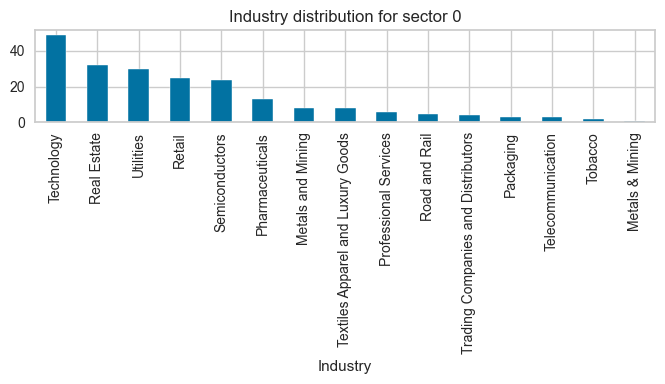

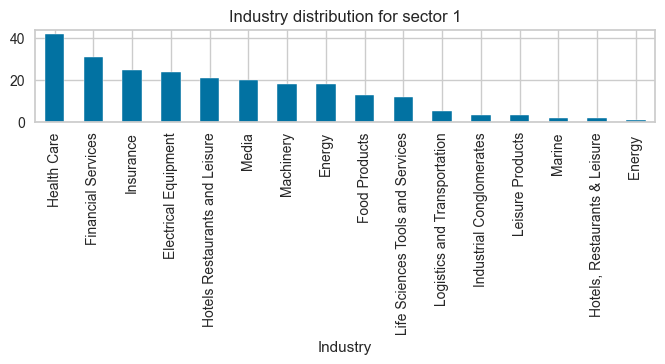

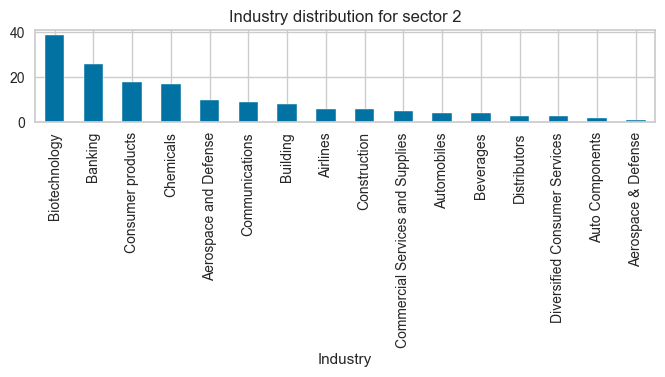

In [296]:
for i in range(N_SECTORS):
    plt.subplot(4,1,i+1)
    datas = sectorized_data[i]
    sectorized_data[i]["industry"].value_counts().plot(kind="bar")

    plt.title(f"Industry distribution for sector {i}")
    plt.xlabel("Industry")
    plt.show()